In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models import resnet50
from torchvision.models.resnet import ResNet50_Weights

import matplotlib.pyplot as plt
import os
from PIL import Image

from typing import List, Tuple, Dict
import gc
from tqdm.notebook import tqdm
import wandb
import yaml

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(torch.cuda.get_device_name(0))

NVIDIA GeForce RTX 3050 Laptop GPU


## Part A - Ques - 1 & 2

### Building a CNN Model

In [26]:
class CNN_Model(nn.Module):
    def __init__(self, height : int = 224, width : int = 224, input_channels : int = 3,
                       hidden_filters : int = 32,
                       kernel_size : int = 3,
                       dense_hidden_size : int = 128,
                       is_normalization : bool = True,
                       is_dropout : bool = True,
                       dropout_rate : float = 0.5,
                       filter_growth : float | None = 1,
                       activation : str = "relu", 
                       dense_activation : str | None = None,
                       output_size : int = 10):
        
        super(CNN_Model, self).__init__()

        # Initializing the attributes
        self.height = height ; self.width = width
        self.dropout_rate = dropout_rate
        self.input_channels = input_channels
        self.hidden_filters = hidden_filters
        self.kernel_size = kernel_size
        self.dense_hidden_size = dense_hidden_size
        self.is_normalization = is_normalization
        self.is_dropout = is_dropout
        self.filter_growth = filter_growth

        self.activation = activation.lower()
        if dense_activation is None:
            self.dense_activation = self.activation

        self.output_size = output_size
        self.max_filter_size = 256

        # defining the activation functions map
        self.activation_map = {
            "relu" : nn.ReLU(),
            "gelu" : nn.GELU(),
            "tanh" : nn.Tanh(),
            "silu" : nn.SiLU(),
            "mish": nn.Mish(),
            "leaky_relu" : nn.LeakyReLU(),
            }
        
        # defining the conv layer
        self.conv_layer = nn.Sequential()
        self.conv_layer.add_module(
            f"conv_block_0",
            nn.Sequential(
            nn.Conv2d(
                in_channels = input_channels,
                out_channels = hidden_filters,
                kernel_size = kernel_size,
                padding = "same"
            ),
            nn.BatchNorm2d(hidden_filters) if is_normalization else nn.Identity(),
            self.activation_map[self.activation],
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            ),
        )

        # for storing the hidden filters
        prev_filers = hidden_filters
        self.height = self.height//2
        self.width = self.width//2

        for i in range(1, 5):
            # adding the conv block
            new_filers = min(self.max_filter_size, int(prev_filers * filter_growth))
            self.conv_layer.add_module(
                f"conv_block_{i}",
                nn.Sequential(
                    nn.Conv2d(
                        in_channels = prev_filers,
                        out_channels = new_filers,
                        kernel_size = kernel_size,
                        padding = "same"
                    ),
                    nn.BatchNorm2d(new_filers) if is_normalization else nn.Identity(),
                    self.activation_map[self.activation],
                    nn.MaxPool2d(kernel_size = 2, stride = 2),
                )
            )
            # updating the prev_filers
            prev_filers = min(new_filers, self.max_filter_size)
            self.height = self.height//2
            self.width = self.width//2
        
        # For flattening the output
        self.conv_layer.add_module(f"Flattening layer",nn.Flatten())

        # adding the dense layer
        self.dense_layer = nn.Sequential(

            nn.Linear(prev_filers * self.height * self.width, dense_hidden_size),
            self.activation_map[self.dense_activation],
            nn.Dropout(self.dropout_rate) if self.is_dropout else nn.Identity(),

            nn.Linear(dense_hidden_size, dense_hidden_size),
            self.activation_map[self.dense_activation],
            nn.Dropout(self.dropout_rate) if self.is_dropout else nn.Identity(),

            nn.Linear(dense_hidden_size, output_size)
        )
    
    def forward(self, x : torch.Tensor) -> torch.Tensor:
        return self.dense_layer(self.conv_layer(x))

In [5]:
example_CNN_Model = CNN_Model(filter_growth=1)
print("Total Learnable weights in the Model : ", sum(p.numel() for p in example_CNN_Model.parameters() if p.requires_grad)*1e-3, "K")
print(f"Total parameters in conv layer : {sum([p.numel() for p in example_CNN_Model.conv_layer.parameters()])*1e-3:.3f} K")
print(f"Total parameters in dense layer : {sum([p.numel() for p in example_CNN_Model.dense_layer.parameters()])*1e-3:.3f} K")

print(f"\nPassing as example input")
example_input = torch.randn(1, 3, 224, 224)
print("Output Shape : ", example_CNN_Model(example_input).shape)

Total Learnable weights in the Model :  256.842 K
Total parameters in conv layer : 38.208 K
Total parameters in dense layer : 218.634 K

Passing as example input
Output Shape :  torch.Size([1, 10])


### Loading Data and Trainer class

In [6]:
# Plotting the images
train_transforms_augmentation = transforms.Compose([

    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(10),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],              # Imagenet stats
                std=[0.229, 0.224, 0.225]) 
])

val_transforms = transforms.Compose([

    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],              #
                std=[0.229, 0.224, 0.225]),
])

""" Train Transforms and Val Transforms 
Train Transforms without augmentation = Val_Transforms, so need to define another time"""

' Train Transforms and Val Transforms \nTrain Transforms without augmentation = Val_Transforms, so need to define another time'

In [7]:
class Trainer():
    def __init__(self, model : CNN_Model, 
                dataset_path : str = "../dataset/inaturalist_12K/train/",
                data_augmentation : bool = True, 
                batch_size : int = 32,
                optimizer_params : Dict = {"lr" : 1e-4},
                loss = nn.CrossEntropyLoss(), ):
        
        # Initializing attributes
        self.model = model
        self.dataset_path = dataset_path
        self.data_augmentation = data_augmentation
        self.batch_size = batch_size
        self.optimizer_params = optimizer_params

        # Train - val split
        self.full_dataset = ImageFolder(root = self.dataset_path, transform = val_transforms)
        train_size = int(0.8 * len(self.full_dataset)) ; val_size = len(self.full_dataset) - train_size

        # creating the datasets
        self.train_dataset, self.val_dataset = random_split(self.full_dataset, [train_size, val_size])
        self.train_dataset.transform = train_transforms_augmentation if self.data_augmentation else val_transforms


        # creating the dataloader
        self.train_dataloader = DataLoader(self.train_dataset, batch_size = self.batch_size, shuffle = True)
        self.val_dataloader = DataLoader(self.val_dataset, batch_size = self.batch_size, shuffle = False)

        # defining the loss fn
        self.loss_fn = loss

        # defining the optimizer
        self.optimizer = torch.optim.Adam(self.model.parameters(), **self.optimizer_params)
        # defining the learning rate scheduler
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='min',        
            factor=0.5,            
            patience=2,            # after 2 epochs without improvement
            verbose=True,
            min_lr=1e-6  
        )

        print(f"Total images in train dataset : {len(self.train_dataset)}")
        print(f"Total images in val dataset : {len(self.val_dataset)}")
        print(f"Total parameters in the model :  {sum([p.numel() for p in self.model.parameters()])*1e-3:.3f} K")
        if self.model.conv_layer is not None:
            print(f"Total parameters in conv layer : {sum([p.numel() for p in self.model.conv_layer.parameters()])*1e-3:.3f} K")
        print(f"Total parameters in dense layer : {sum([p.numel() for p in self.model.dense_layer.parameters()])*1e-3:.3f} K")
    
    def validate_model(self):

        self.model.eval()
        val_loss = 0
        val_accuracy = 0

        with torch.no_grad():
            for images, labels in self.val_dataloader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = self.model(images)
                loss = self.loss_fn(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                val_accuracy += (predicted == labels).sum().item()

                # for memory management
                del images, labels
                torch.cuda.empty_cache()
                gc.collect()

        return val_loss/len(self.val_dataloader), val_accuracy/len(self.val_dataloader.dataset)

    def train_model(self, epochs : int = 10):

        
        train_loss_history = []
        train_accuracy_history = []
        val_loss_history = []
        val_accuracy_history = []

        loop_obj = tqdm(range(epochs))

        for epoch in loop_obj:

            train_loss = 0
            train_accuracy = 0
            self.model.train()

            for images, labels in tqdm(self.train_dataloader):
                images = images.to(device)
                labels = labels.to(device)

                outputs = self.model(images)
                loss = self.loss_fn(outputs, labels)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                train_accuracy += (predicted == labels).sum().item()

                del images, labels
                torch.cuda.empty_cache()
                gc.collect()

            # adding the train and val : loss and accuracy
            train_loss_history.append(train_loss/len(self.train_dataloader))
            train_accuracy_history.append(train_accuracy/len(self.train_dataloader.dataset))

            # doing validation
            val_loss, val_accuracy = self.validate_model()
            val_loss_history.append(val_loss)  
            val_accuracy_history.append(val_accuracy)

            loop_obj.set_description(f"Epoch {epoch+1}/{epochs}")
            loop_obj.set_postfix(
                Train_loss = train_loss_history[-1],
                Train_accuracy = train_accuracy_history[-1],
                Val_loss = val_loss_history[-1],
                Val_accuracy = val_accuracy_history[-1],
            )

            # step the scheduler, after calculating val loss
            self.scheduler.step(val_loss)

        self.train_loss_history = train_loss_history
        self.train_accuracy_history = train_accuracy_history
        self.val_loss_history = val_loss_history
        self.val_accuracy_history = val_accuracy_history

        return {"train_loss" : train_loss_history,
                "train_accuracy" : train_accuracy_history, 
                "val_loss" : val_loss_history, 
                "val_accuracy" : val_accuracy_history}

In [8]:
### Sample Training
sample_cnn_model = CNN_Model(height = 224, width = 224, input_channels = 3,
                       hidden_filters = 16, filter_growth = 2,
                       kernel_size = 3, dense_hidden_size = 128,
                       is_normalization = True, is_dropout = True, dropout_rate = 0.5,
                       output_size = 10, activation = "relu").to(device)

print(f"Total parameters in the model :  {sum([p.numel() for p in sample_cnn_model.parameters()])*1e-3:.3f} K")
print(f"Total parameters in conv layer : {sum([p.numel() for p in sample_cnn_model.conv_layer.parameters()])*1e-3:.3f} K")
print(f"Total parameters in dense layer : {sum([p.numel() for p in sample_cnn_model.dense_layer.parameters()])*1e-3:.3f} K")

Total parameters in the model :  886.946 K
Total parameters in conv layer : 191.640 K
Total parameters in dense layer : 695.306 K


In [9]:
sample_trainer = Trainer(model = sample_cnn_model, 
                         dataset_path = "../dataset/inaturalist_12K/train/", 
                         data_augmentation = True, 
                         batch_size = 64, 
                         optimizer_params = {"lr" : 1e-4})

# sample_trainer_history = sample_trainer.train_model(epochs = 1)

Total images in train dataset : 7999
Total images in val dataset : 2000
Total parameters in the model :  886.946 K
Total parameters in conv layer : 191.640 K
Total parameters in dense layer : 695.306 K


### Making wandb logs

In [10]:
wandb.login(key="878d8077f96e35def15932addea71a0302e0dede")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\pcdpm\_netrc
wandb: Currently logged in as: shivasurya (shivasurya-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
def train_with_wandb():

    run = wandb.init()
    config = wandb.config
    run.name = f"act_fn : {config.activation_function} _ hidden_filters : {config.num_filters} _ kernel_size : {config.kernel_size} _ filter_growth : {config.filter_growth}"

    # if config.num_filters > 50 and config.filter_growth > 1:
    #     wandb.finish()
    #     return

    # creating trainer
    cnn_model = CNN_Model(height = 224, width = 224, input_channels = 3,
                       hidden_filters = config.num_filters, filter_growth = config.filter_growth,
                       kernel_size = config.kernel_size, dense_hidden_size = 128,
                       is_normalization = config.batch_norm, is_dropout = True, dropout_rate = config.dropout,
                       output_size = 10, activation = config.activation_function).to(device)
    
    trainer_wandb = Trainer(model = cnn_model, 
                         dataset_path = "../dataset/inaturalist_12K/train/", 
                         data_augmentation = config.data_augmentation, 
                         batch_size = 64, 
                         optimizer_params = {"lr" : 1e-4})
    
    stats = trainer_wandb.train_model(epochs = 5)

    # for memory management
    del cnn_model
    del trainer_wandb
    torch.cuda.empty_cache()
    gc.collect()

    for i in range(0, len(stats['train_loss'])):

        wandb.log({
                "epoch": i,
                "train_accuracy" : stats['train_accuracy'][i],
                "train_loss": stats['train_loss'][i],
                "val_loss" : stats['val_loss'][i],
                "val_accuracy": stats['val_accuracy'][i],
            })

In [ ]:
with open("./config/sweep_config.yaml", "r") as f:
    sweep_config = yaml.safe_load(f)

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="DA6401-assig-2")
wandb.agent(sweep_id, function=train_with_wandb)

In [ ]:
### Running for 15 epoch for model with good hyperparameters

# Set default config values for the run
best_model_config = {
    "num_filters": 64,
    "activation_function": "GeLU",
    "filter_growth": 2,
    "kernel_size": 3,
    "batch_norm": True,
    "data_augmentation": True,
    "dropout": 0.5,
    "epochs": 15,
}

def best_model_train():

    run = wandb.init(config = best_model_config,
                    project="DA6401-assig-2")
    config = wandb.config
    run.name = f"act_fn : {config.activation_function} _ hidden_filters : {config.num_filters} _ kernel_size : {config.kernel_size} _ filter_growth : {config.filter_growth} _ epochs = {config.epochs}"

    # if config.num_filters > 50 and config.filter_growth > 1:
    #     wandb.finish()
    #     return

    # creating trainer
    global cnn_model
    cnn_model = CNN_Model(height = 224, width = 224, input_channels = 3,
                       hidden_filters = config.num_filters, filter_growth = config.filter_growth,
                       kernel_size = config.kernel_size, dense_hidden_size = 128,
                       is_normalization = config.batch_norm, is_dropout = True, dropout_rate = config.dropout,
                       output_size = 10, activation = config.activation_function).to(device)


    trainer_wandb = Trainer(model = cnn_model, 
                         dataset_path = "../dataset/inaturalist_12K/train/", 
                         data_augmentation = config.data_augmentation, 
                         batch_size = 64, 
                         optimizer_params = {"lr" : 3e-4})
    
    stats = trainer_wandb.train_model(epochs = config.epochs)

    # saving the model for future use
    torch.save(cnn_model.state_dict(), f"../weights/model_{stats['val_accuracy'][-1]*100:.3f}.pth")

    # for memory management
    # del cnn_model
    # del trainer_wandb
    torch.cuda.empty_cache()
    gc.collect()

    for i in range(0, len(stats['train_loss'])):

        wandb.log({
                "epoch": i,
                "train_accuracy" : stats['train_accuracy'][i],
                "train_loss": stats['train_loss'][i],
                "val_loss" : stats['val_loss'][i],
                "val_accuracy": stats['val_accuracy'][i],
            })

In [ ]:
best_model_train()

### For Testing - Ques 4

In [18]:
class tester():
    def __init__(self, 
                 model, 
                 test_dataset_path,
                 shuffle_data : bool = False):

        self.model = model
        self.test_path = test_dataset_path

        self.test_dataloader = DataLoader(ImageFolder(root = self.test_path, transform = val_transforms), batch_size = 32, shuffle = shuffle_data)

    def test_model(self):

        self.model.eval()
        test_prediction = []
        true_labels = []
        test_images = []
        confidence_scores = []

        with torch.no_grad():
            correct = 0
            total = 0

            for images, labels in tqdm(self.test_dataloader):
                images = images.to(device)
                labels = labels.to(device)

                outputs = self.model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                # appending the prediction and true labels
                test_prediction.append(predicted.cpu().numpy())
                true_labels.append(labels.cpu().numpy())
                test_images.append(images.cpu().numpy())
                confidence_scores.append(torch.max(torch.nn.functional.softmax(outputs, dim=1), dim = 1).values.cpu().numpy())

                # for memory management
                del images, labels
                torch.cuda.empty_cache()
                gc.collect()
        
        return np.concatenate(test_images), np.concatenate(test_prediction), np.concatenate(true_labels), np.concatenate(confidence_scores), correct/total

In [22]:
import matplotlib.patches as patches

def plot_images(images, test_prediction, true_labels, confidence_scores, ind_to_cls, samples_size=30, save_path = None):
    # Compute overall test accuracy
    correct = np.sum(np.array(test_prediction) == np.array(true_labels))
    total = len(true_labels)
    accuracy = (correct / total) * 100

    # Set figure background color to white
    plt.figure(figsize=(13, 40), facecolor='white')

    # Add title with accuracy
    plt.suptitle(f"Model Predictions on Test Set — Accuracy: {accuracy:.2f}%", fontsize=20)

    # Random sample of indices
    samples = np.random.randint(0, len(images), samples_size)
    cols = 3
    rows = int(np.ceil(samples_size / cols))

    for i, ind in enumerate(samples):
        ax = plt.subplot(rows, cols, i + 1)

        # Set individual subplot background color to dark gray
        ax.set_facecolor("white")  # Make sure the subplot background is white

        img = Image.open(images[ind][0]).convert("RGB").resize((512, 512))
        plt.imshow(img)

        pred_label = ind_to_cls[test_prediction[ind]]
        true_label = ind_to_cls[true_labels[ind]]
        confidence = confidence_scores[ind] * 100

        # Add thick rectangle around the image
        rect_color = "green" if pred_label == true_label else "red"
        rect = patches.Rectangle(
            (0, 0), img.size[0], img.size[1],
            linewidth=5, edgecolor=rect_color, facecolor='none'
        )
        ax.add_patch(rect)

        # Set title
        title = f"Pred: {pred_label} ({confidence:.2f}%)\nTrue: {true_label}"
        ax.set_title(title, fontsize=13, color=rect_color)

        # Turn off axis ticks and labels
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

    # Ensure the layout looks neat and adjust spacing to make room for the title
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    if save_path != None:
        plt.savefig(save_path, facecolor = "white", bbox_inches='tight',)
    plt.show()



In [27]:
# loading one of the best model
test_model = CNN_Model(height = 224, width = 224, input_channels = 3,
                       hidden_filters = 64, filter_growth = 2,
                       kernel_size = best_model_config['kernel_size'], dense_hidden_size = 128,
                       is_normalization = best_model_config['batch_norm'], is_dropout = True, dropout_rate = 0.5,
                       output_size = 10, activation = best_model_config['activation_function']).to(device)

test_model.load_state_dict(torch.load("../weights/model_45.90.pth"))

sample_tester = tester(model = test_model, test_dataset_path = "../dataset/inaturalist_12K/val/")

In [28]:
stats = sample_tester.test_model()
print(f"Accuracy in Test data : {stats[4]**100:.3f}%")

  0%|          | 0/63 [00:00<?, ?it/s]

Accuracy in Test data : 0.000%


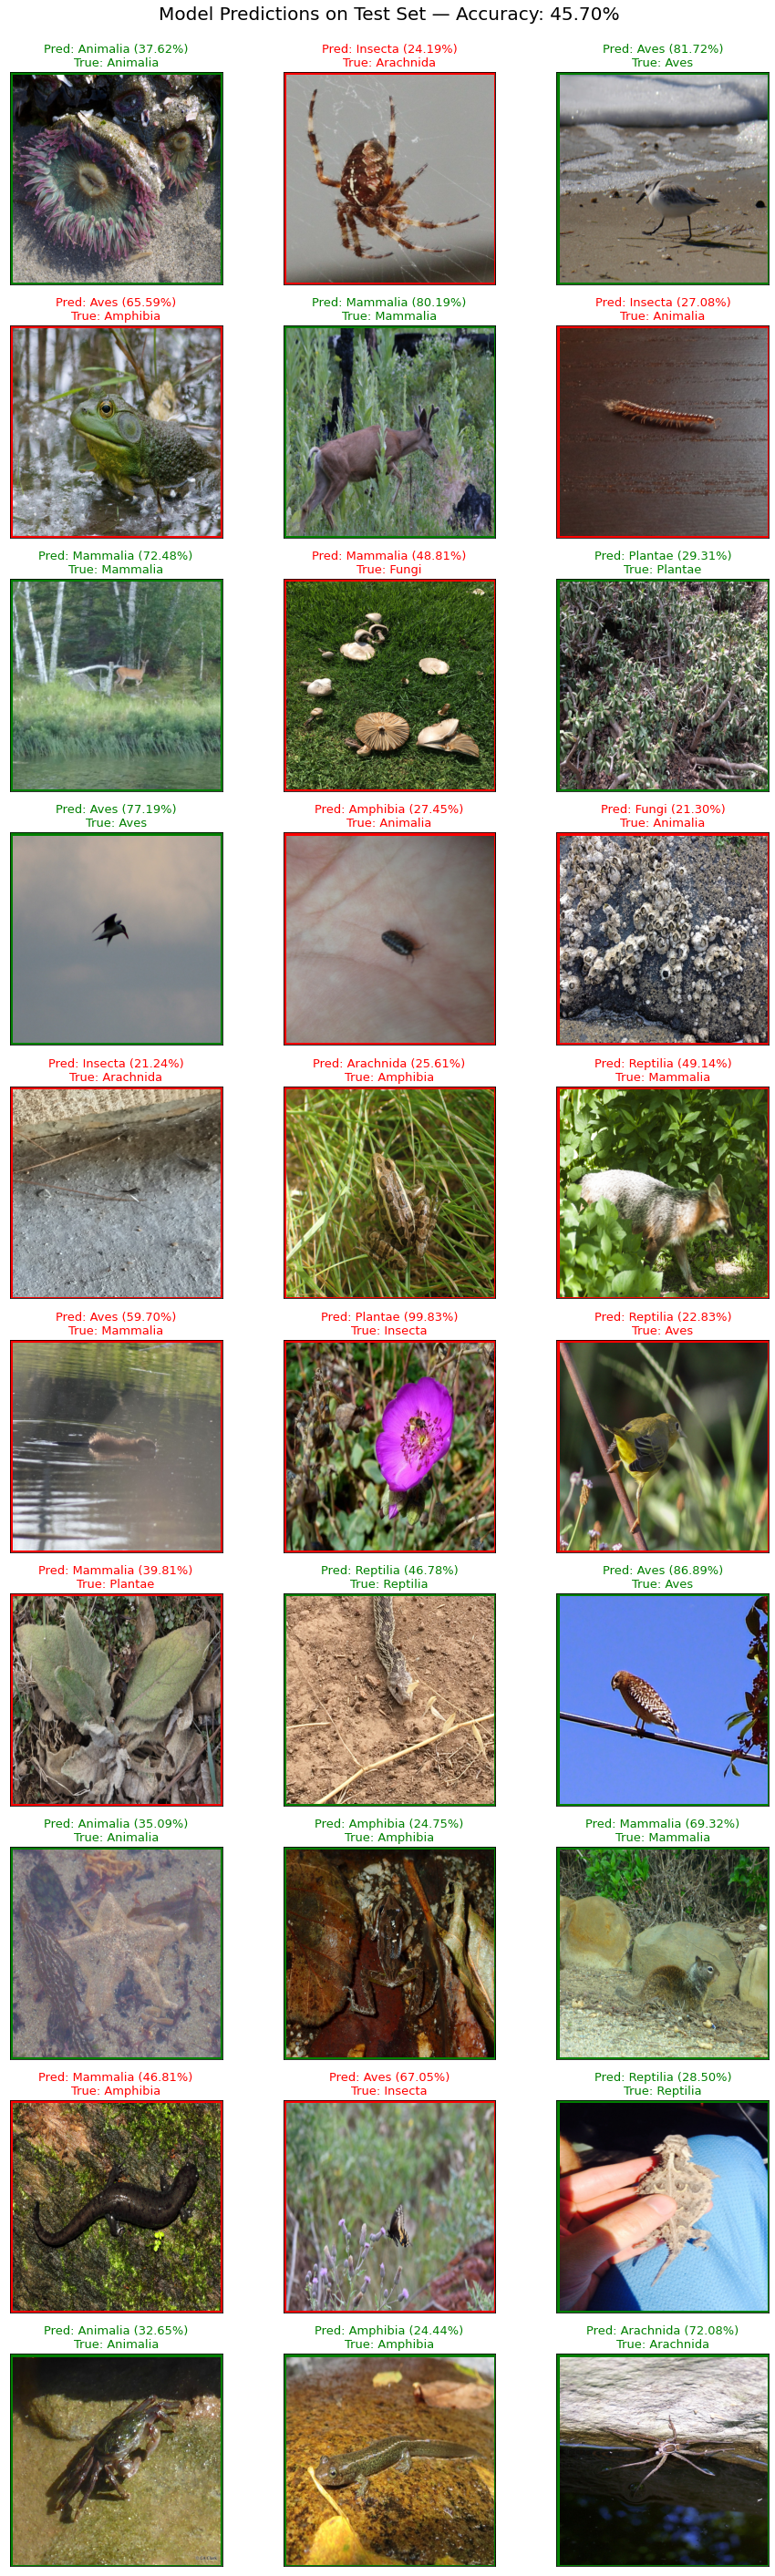

In [ ]:
plot_images(images = sample_tester.test_dataloader.dataset.imgs, 
            test_prediction = stats[1], 
            true_labels = stats[2], 
            confidence_scores = stats[3],
            ind_to_cls = sample_tester.test_dataloader.dataset.classes,
            save_path = "../images/test_data_predictions_45.png")

In [68]:
# logging the image into wandb
wandb.init(project="DA6401-assig-2", name = "Test_image_logging", reinit=True)
test_prediction_image = Image.open("../images/test_data_predictions.png") 

# Log the image to wandb
wandb.log({
    "test_pred_image_1": wandb.Image(test_prediction_image, caption="Test prediction image")
    
})

wandb.finish()

## Ques - 2 using a pre-trained network (resnet-50)

In [ ]:
# resnet_custom = resnet50(weights = ResNet50_Weights.IMAGENET1K_V1)
# sum([p.numel() for p in resnet_custom.layer4[-1].conv2.parameters()]) / 1e6

# resnet_custom.layer4[-1].conv3

Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)

In [56]:
class CNN_ResNet50(nn.Module):
    def __init__(self, dense_hidden_size: int = 128,
                       is_dropout: bool = True, dropout_rate: float = 0.5, 
                       activation: str = "relu", 
                       output_size: int = 10,):
        
        super(CNN_ResNet50, self).__init__()
        activation = activation.lower()

        # Defining the activation function map
        self.activation_map = {
            "relu": nn.ReLU(),
            "gelu": nn.GELU(),
            "tanh": nn.Tanh(),
            "silu": nn.SiLU(),
            "mish": nn.Mish(),
            "leaky_relu": nn.LeakyReLU(),
        }

        # Load the pre-trained ResNet-50 model
        resnet50_model = resnet50(weights = ResNet50_Weights.IMAGENET1K_V1)
        self.conv_layer = None

        # Freeze all layers in ResNet-50
        for param in resnet50_model.parameters():
            param.requires_grad = False
        
        # Number of input features to the final FC layer
        num_ftrs = resnet50_model.fc.in_features 

        # Unfreezing last three conv layers
        # for block in resnet50_model.layer4[-1].parameters():
        for p in resnet50_model.layer4[-1].conv3.parameters():
            p.requires_grad = True
        
        # Replace the last fully connected layer to match the output size for iNaturalist
        self.features = nn.Sequential(*list(resnet50_model.children())[:-1])  # All layers except the final FC layer 
        self.features.add_module(f"Flattening layer",nn.Flatten()) # adding a flatten layer

        self.dense_layer = nn.Sequential(

            nn.Linear(num_ftrs, dense_hidden_size),  # Custom fully connected layer
            self.activation_map[activation],
            nn.Dropout(dropout_rate) if is_dropout else nn.Identity(),

            nn.Linear(dense_hidden_size, dense_hidden_size),
            self.activation_map[activation],
            nn.Dropout(dropout_rate) if is_dropout else nn.Identity(),

            nn.Linear(dense_hidden_size, output_size)  # Final output size
        )

    def forward(self, x):
        x = self.features(x)
        x = self.dense_layer(x)
        return x

In [58]:
sample_cnn_resnet50 = CNN_ResNet50(dense_hidden_size = 128, is_dropout = True, dropout_rate = 0.5,
                                  activation = "relu", output_size = 10)

print(f"Total parameters in the model :  {sum([p.numel() for p in sample_cnn_resnet50.parameters()])*1e-3:.3f} K")
print(f"Total parameters in dense layer : {sum([p.numel() for p in sample_cnn_resnet50.dense_layer.parameters()])*1e-3:.3f} K")
print(f"Total Trainable params in the network : {sum([p.numel() for p in sample_cnn_resnet50.parameters() if p.requires_grad])*1e-3:.3f} K")

Total parameters in the model :  23788.106 K
Total parameters in dense layer : 280.074 K
Total Trainable params in the network : 1328.650 K


In [59]:
sample_resnet_trainer = Trainer(model = sample_cnn_resnet50.to(device), 
                         dataset_path = "../dataset/inaturalist_12K/train/", 
                         data_augmentation = True, 
                         batch_size = 64, 
                         optimizer_params = {"lr" : 1e-4}, )

# stats = sample_resnet_trainer.train_model(epochs = 1)

Total images in train dataset : 7999
Total images in val dataset : 2000
Total parameters in the model :  23788.106 K
Total parameters in dense layer : 280.074 K


### wandb sweeps with the pre-trained model

In [62]:
def train_resnet_with_wandb():

    run = wandb.init()
    config = wandb.config
    run.name = f"act_fn : {config.activation_function} _ dense : {config.dense_hidden_size} _ dropout : {config.dropout} _ LastConv : True"

    # creating trainer
    cnn_model = CNN_ResNet50(dense_hidden_size = config.dense_hidden_size, is_dropout = True, dropout_rate = config.dropout,
                                  activation = config.activation_function, output_size = 10).to(device)
    
    trainer_wandb = Trainer(model = cnn_model, 
                         dataset_path = "../dataset/inaturalist_12K/train/", 
                         data_augmentation = config.data_augmentation, 
                         batch_size = 64, 
                         optimizer_params = {"lr" : 1e-4})
    
    stats = trainer_wandb.train_model(epochs = 5)

    checkpoint = {
    "model_state_dict": cnn_model.dense_layer.state_dict(),  
    "hyperparameters": dict(config),  # Save the hyperparameters used in the config
    "max_val_accuracy" : max(stats['val_accuracy']), 
    "last_val_accuracy" : stats['val_accuracy'][-1],
    "max_val_epoch" : stats['val_accuracy'].index(max(stats['val_accuracy'])),   
    }

    # for memory management
    del cnn_model
    del trainer_wandb
    torch.cuda.empty_cache()
    gc.collect()

    torch.save(checkpoint, f"../weights/resnet_model_{stats['val_accuracy'][-1]*100:.3f}.pth")  

    for i in range(0, len(stats['train_loss'])):

        wandb.log({
                "epoch": i,
                "train_accuracy" : stats['train_accuracy'][i],
                "train_loss": stats['train_loss'][i],
                "val_loss" : stats['val_loss'][i],
                "val_accuracy": stats['val_accuracy'][i],
            })

In [30]:
with open("./config/resnet_sweep_config.yaml", "r") as f:
    sweep_config_resnet = yaml.safe_load(f)

In [64]:
# sweep_id_resnet = wandb.sweep(sweep_config_resnet, project="DA6401-assig-2")

sweep_id_resnet = "shivasurya-iit-madras/DA6401-assig-2/byx5jfzr"
wandb.agent(sweep_id_resnet, function=train_resnet_with_wandb, count = 5)

wandb: Agent Starting Run: 3dclwuqy with config:
wandb: 	activation_function: Mish
wandb: 	data_augmentation: True
wandb: 	dense_hidden_size: 128
wandb: 	dropout: 0.25
wandb: 	pretrained: True


Total images in train dataset : 7999
Total images in val dataset : 2000
Total parameters in the model :  23788.106 K
Total parameters in dense layer : 280.074 K


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

wandb: Agent Starting Run: ti5h4h68 with config:
wandb: 	activation_function: Mish
wandb: 	data_augmentation: True
wandb: 	dense_hidden_size: 128
wandb: 	dropout: 0.25
wandb: 	pretrained: True


Total images in train dataset : 7999
Total images in val dataset : 2000
Total parameters in the model :  23788.106 K
Total parameters in dense layer : 280.074 K


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

wandb: Agent Starting Run: ddqhbkjg with config:
wandb: 	activation_function: Mish
wandb: 	data_augmentation: True
wandb: 	dense_hidden_size: 128
wandb: 	dropout: 0.25
wandb: 	pretrained: True


Total images in train dataset : 7999
Total images in val dataset : 2000
Total parameters in the model :  23788.106 K
Total parameters in dense layer : 280.074 K


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

wandb: Network error (ConnectTimeout), entering retry loop.


wandb: Sweep Agent: Waiting for job.
wandb: Ctrl + C detected. Stopping sweep.
